# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd
from tqdm import tqdm

38252


In [2]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'save_folder':r'\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'experiment_type': 'DNA',
             'num_threads': 25,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':10,
                     'max_num_seeds': 2000,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False
                 }, 
             }

## 1.1 define required floders

In [3]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation', 'Tests')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots', 'Tests')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


163 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests
Use cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\Tests
Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests


In [4]:
save_figure = True
#figure_folder = os.path.join(save_folder, 'Figures_final')
figure_folder = os.path.join(decoder_folder, 'Figures_final')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

Create figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests\Figures_final


## 1.2 get dict for cell uid

In [5]:
%%time
_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')

fovcell_2_uid = {}
with h5py.File(_total_seg_save_file, 'r') as _f:
    for _fov_id in _f.keys():
        _fov_group = _f[_fov_id]
        _uid_group = _fov_group['cell_2_uid']
        for _cell_id in _uid_group.keys():
            fovcell_2_uid[(_fov_id, _cell_id)] = _uid_group[_cell_id][:][0]
print(len(fovcell_2_uid))

22712
Wall time: 13.5 s


## 1.3 get cell_uid to cell-class

In [6]:
%%time
import scanpy as sc

# load cell type info
merfish_cluster_file = r'\\mendel\Mendel_SSD1\Pu_Temp\20220208MO4_nonclear\filtered_cluster_data_labeled.h5ad'

merfish_df = sc.read_h5ad(merfish_cluster_file)

uid_2_class = {_uid:_class for _uid, _class in zip(merfish_df.obs.index, merfish_df.obs['subclass_manual_label'])}

Wall time: 5.71 s


# 2. export spot_groups

In [33]:
# test loading
_export_filename = os.path.join(export_decode_folder, f"DecodeGroup_Fov-{save_fov_ids[0]}.hdf5")
pd.read_hdf(_export_filename, 'Cell-1')

# 3. load chr_2_zxys_list

## 3.1 load codebook

In [7]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

name    id  NDB_784  NDB_755  NDB_826  NDB_713  NDB_865  \
0        1:3740000-3760000     1        0        0        0        0        0   
1        1:6240000-6260000     2        0        0        0        0        0   
2        1:8740000-8760000     3        0        0        0        0        0   
3      1:11240000-11260000     4        0        0        0        0        0   
4      1:13740000-13760000     5        0        0        0        0        0   
..                     ...   ...      ...      ...      ...      ...      ...   
983  X:161240000-161260000  1057        0        0        1        0        0   
984  X:163740000-163760000  1058        0        0        0        0        0   
985  X:166240000-166260000  1059        0        0        0        0        0   
986  X:168740000-168760000  1060        0        0        0        0        0   
987      Y:1240000-1260000  1062        0        0        0        0        0   

     NDB_725  NDB_817  NDB_710  ...  NDB_824  NDB_712  NDB_818  NDB_940  \
0          0        0        0  ...        0        0        0        0   
1          0        0        0  ...        0        0        0        0   
2          0        0        0  ...        0        0        0        0   
3          0        0        0  ...        0        0        0        1   
4          0        0        0  ...        0        0        1        0   
..       ...      ...      ...  ...      ...      ...      ...      ...   
983        0        0        0  ...        0        0        0        0   
984        0        0        0  ...        0        0        0        0   
985        1        0        0  ...        0        0        0        0   
986        0        0        0  ...        0        0        0        0   
987        0        0        1  ...        0        0        0        0   

     NDB_872  NDB_934  NDB_926  NDB_910  chr  chr_order  
0          0        0        0        0    1          0  
1          0        0        0        0    1          1  
2          0        0        0        0    1          2  
3          0        0        0        0    1          3  
4          0        0        0        0    1          4  
..       ...      ...      ...      ...  ...        ...  
983        0        1        0        0    X         52  
984        1        0        0        0    X         53  
985        0        0        0        0    X         54  
986        0        0        0        0    X         55  
987        0        0        0        0    Y          0  

[988 rows x 103 columns]

## 3.2 load chr_2_zxys_list

In [8]:
import re
import multiprocessing as mp
from ImageAnalysis3.classes.decode import load_hdf5_dict
from ImageAnalysis3.classes.decode import DNA_Merfish_Decoder

#decoder_folder = os.path.join(save_folder, 'Decoder')
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                     if '_Decoder.hdf5' in _fl]
print(decoder_folder, len(decoder_filenames))

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests 18720


In [9]:
%%time
overwrite_coodinates=False

print("Batch load chr_2_zxys")
# Batch loading
load_args = [(_fl, 'chr_2_zxys_list') for _fl in decoder_filenames]
print(len(load_args))
with mp.Pool(44) as load_pool:
    all_chr_2_zxys_list = load_pool.starmap(load_hdf5_dict, 
                                            load_args, 
                                            chunksize=1)
    load_pool.close()
    load_pool.join()
    load_pool.terminate()
    
# Batch summarize
kept_decoder_filenames = [_fl for _fl,_item in zip(decoder_filenames, all_chr_2_zxys_list) if _item is not None]
all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
print(len(kept_decoder_filenames), len(all_chr_2_zxys_list))
# UIDs    
uid_list = [fovcell_2_uid[
    re.findall(r'Fov-([0-9]+)_Cell-([0-9]+)_Decoder.hdf5', os.path.basename(_fl))[0]
           ] for _fl in kept_decoder_filenames]

Batch load all_zxys_list
18720
18718 18718
Wall time: 50.5 s


## 3.3 split chr_zxys into classes

In [27]:
class_2_chr_zxys = {}
for _class in np.unique(merfish_df.obs['subclass_manual_label']):
    if _class not in class_2_chr_zxys:
        class_2_chr_zxys[_class] = []
    for _uid, _chr_zxys in zip(uid_list, all_chr_2_zxys_list):
        if isinstance(_uid, np.bytes_):
            _uid = _uid.decode()
        if _uid in uid_2_class and uid_2_class[_uid] == _class:
            class_2_chr_zxys[_class].append(_chr_zxys)

In [28]:
len(class_2_chr_zxys['Astro'])

999

In [29]:
# save
save_class_2_chr_zxys = os.path.join(decoder_folder, f"class_2_chr_zxys_n{len(all_chr_2_zxys_list)}.pkl")
print(save_class_2_chr_zxys)
pickle.dump(class_2_chr_zxys, open(save_class_2_chr_zxys, 'wb'))

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests\class_2_chr_zxys_n18718.pkl


In [30]:
from ImageAnalysis3.structure_tools import distance
reload(ia.structure_tools.distance)
# summary
summary_classes = []
summary_args = []
for _cls, _dicts in class_2_chr_zxys.items():
    summary_classes.append(_cls)
    summary_args.append( (_dicts, codebook_df) )
print(len(summary_classes))

21


In [31]:
%%time
print(len(summary_args))
with mp.Pool(44) as summary_pool: 
    summary_dicts = summary_pool.starmap(distance.batch_convert_Chr2ZxysList, 
                                         summary_args, chunksize=1)
    summary_pool.close()
    summary_pool.join()
    summary_pool.terminate()
class_2_summary_dict = {_cls:_dict for _cls,_dict in zip(summary_classes, summary_dicts) if _cls != 'Other'}

21
Wall time: 9min 59s


In [32]:
# save
save_class_2_summary_dict = os.path.join(decoder_folder, f"class_2_summary_dict_n{len(all_chr_2_zxys_list)}.pkl")
print(save_class_2_summary_dict)
pickle.dump(class_2_summary_dict, open(save_class_2_summary_dict, 'wb'))

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests\class_2_summary_dict_n18718.pkl


## 3.4 plot cell-type cis-trans

In [33]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {str(_chr):np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


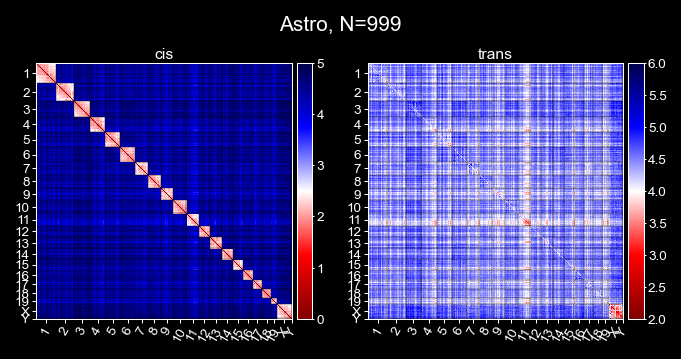

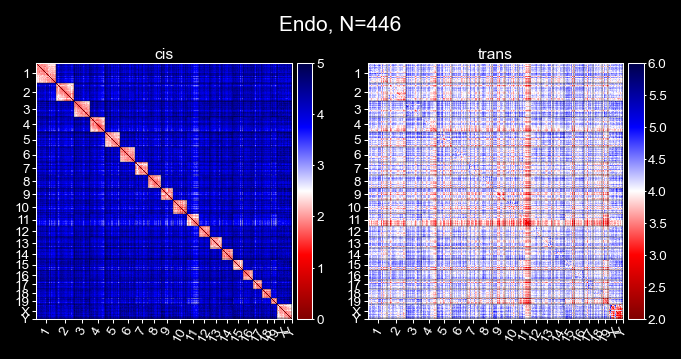

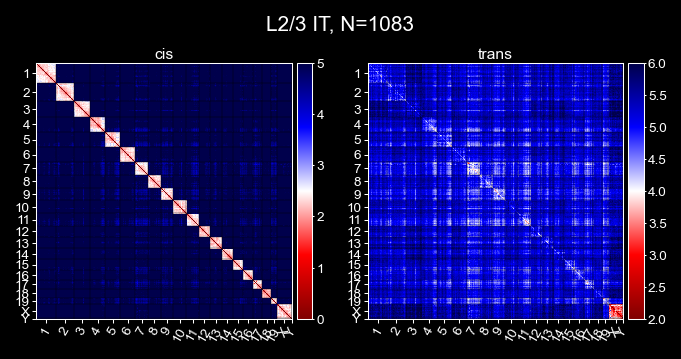

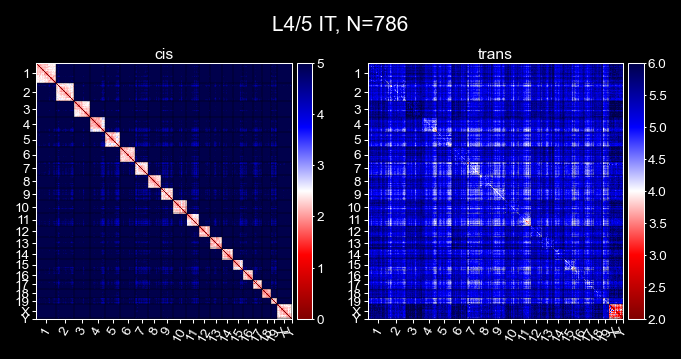

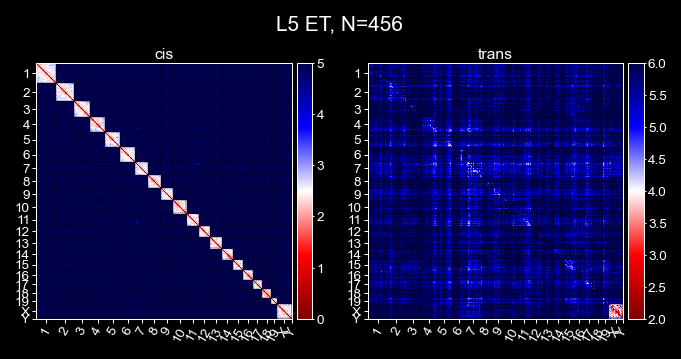

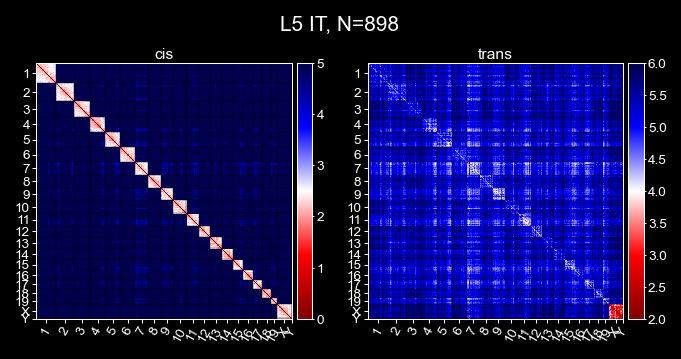

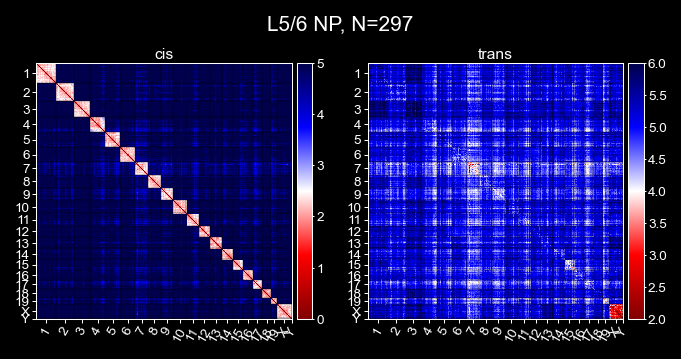

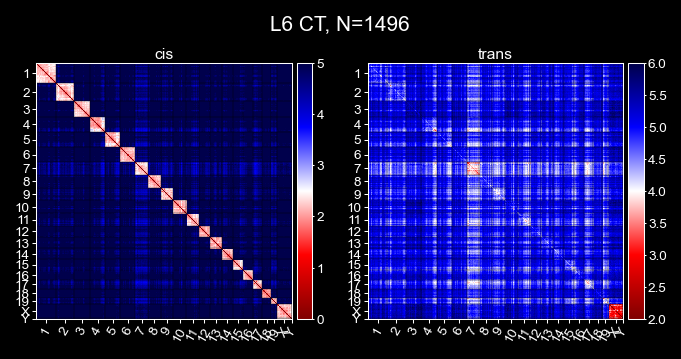

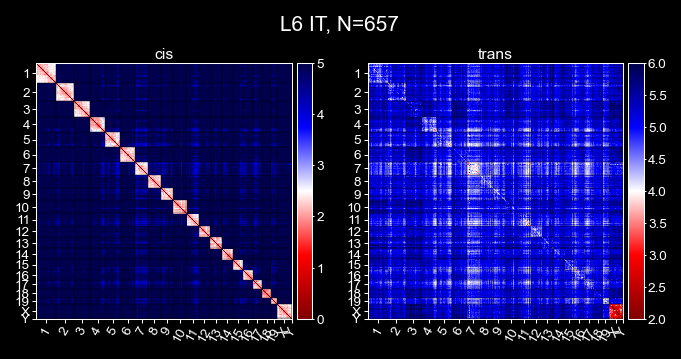

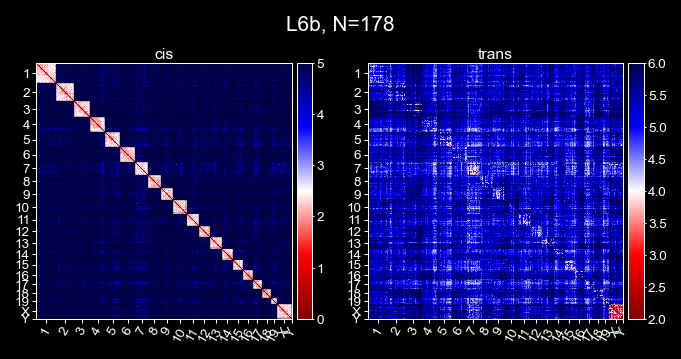

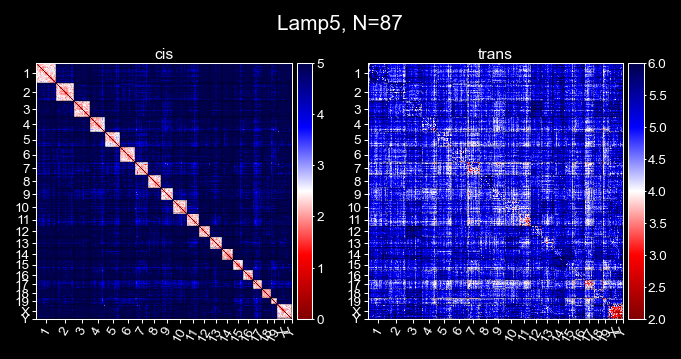

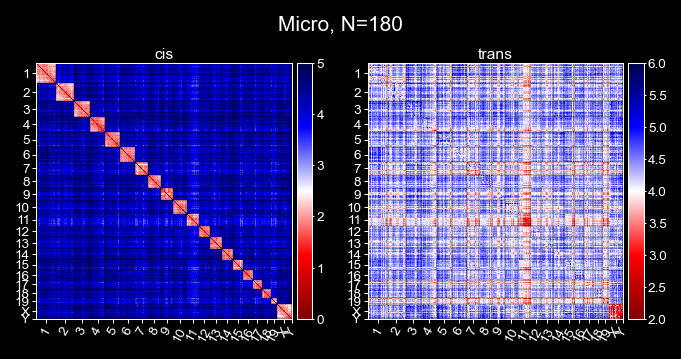

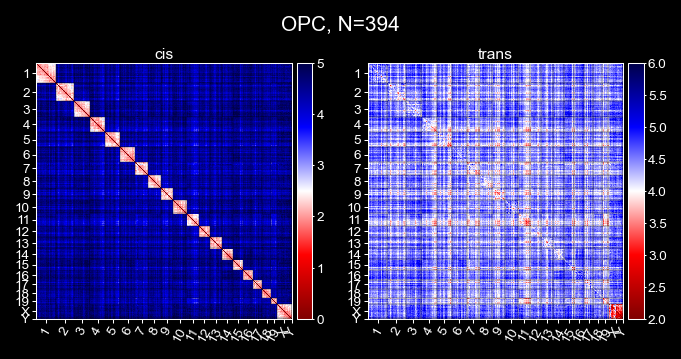

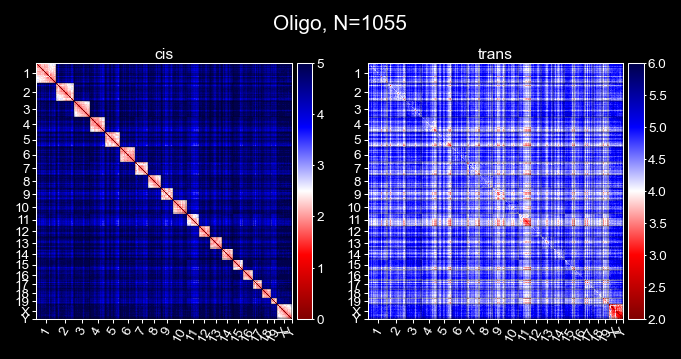

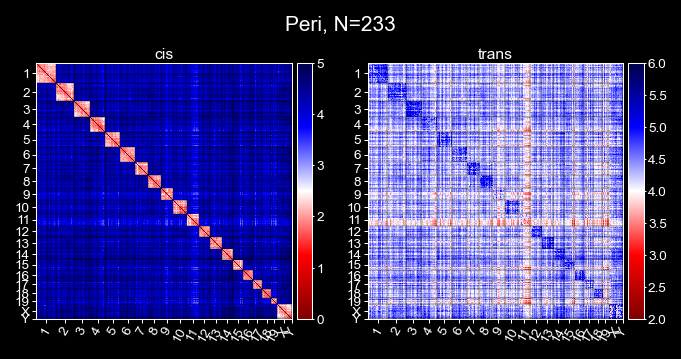

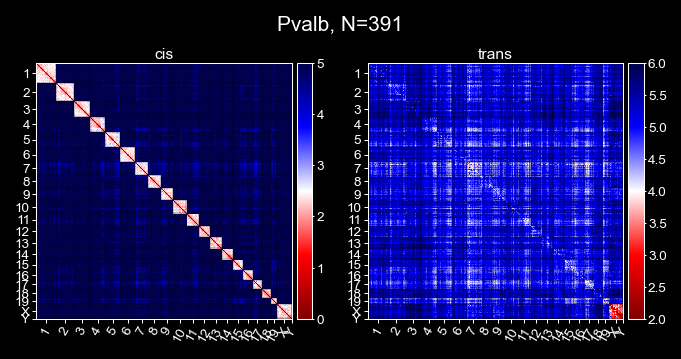

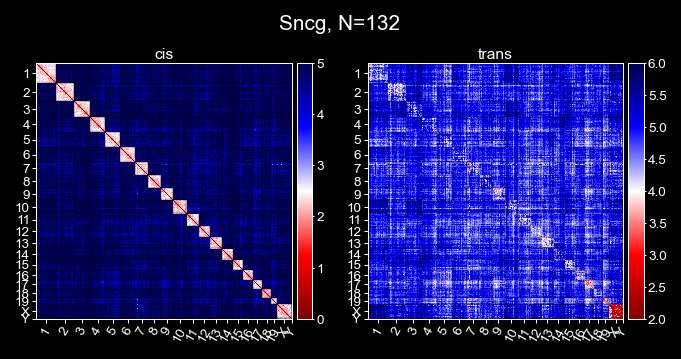

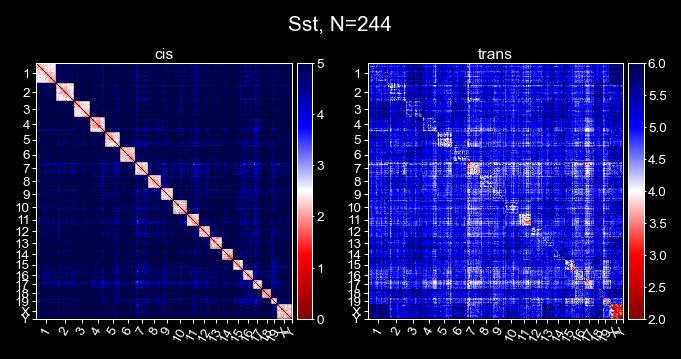

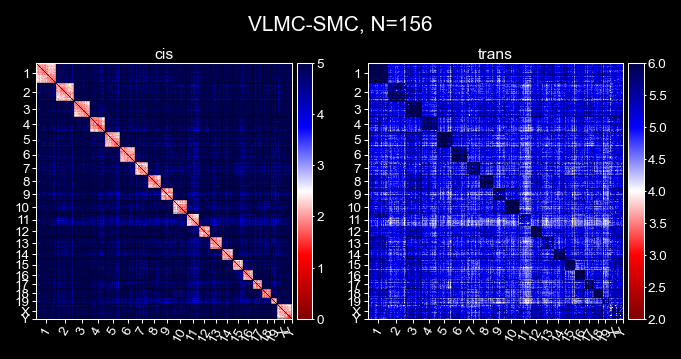

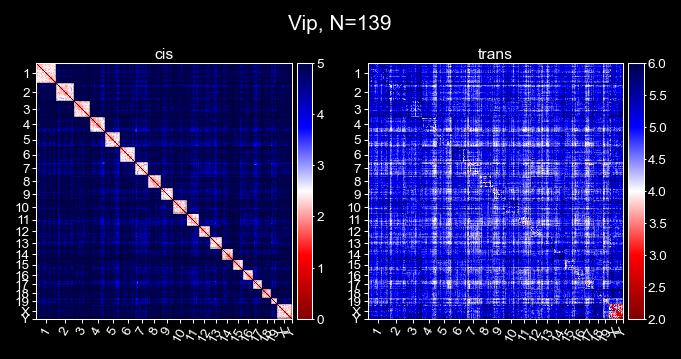

In [34]:
%matplotlib inline
_single_im_size=2.25
plt.style.use('dark_background')

for _class, summary_dict in class_2_summary_dict.items():
    _cis_mat = distance.assemble_ChrDistDict_2_Matrix(summary_dict, codebook_df, use_cis=True)/1000
    _trans_mat = distance.assemble_ChrDistDict_2_Matrix(summary_dict, codebook_df, use_cis=False)/1000

    fig, axes = plt.subplots(1, 2, figsize=(_single_im_size*2, _single_im_size*1.1), dpi=150, sharex=True, sharey=True)

    ia.figure_tools.distmap.plot_distance_map(_cis_mat, color_limits=[0,5],
                                              ax=axes[0], 
                                              ticks=(_labels_edges[1:] + _labels_edges[:-1])/2,
                                              tick_labels=_ordered_chr_names,
                                              font_size=6.5)
    ia.figure_tools.distmap.plot_distance_map(_trans_mat, color_limits=[2,6],
                                              ax=axes[1], 
                                              ticks=(_labels_edges[1:] + _labels_edges[:-1])/2,
                                              tick_labels=_ordered_chr_names, 
                                              font_size=6.5)

    axes[0].set_title(f'cis', fontsize=7.5, pad=2)
    axes[1].set_title(f'trans', fontsize=7.5, pad=2)
    for _ax in axes:
        _ax.hlines(_labels_edges, 0, len(_cis_mat), color='black', linewidth=0.2)
        _ax.vlines(_labels_edges, 0, len(_cis_mat), color='black', linewidth=0.2)
        _ax.xaxis.set_tick_params(which='both', labelbottom=True)
        _ax.yaxis.set_tick_params(which='both', labelleft=True)
    
    fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.97, bottom=0.02)
    fig.suptitle(f"{_class}, N={len(class_2_chr_zxys[_class])}", fontsize=10, y=0.97)
    fig.savefig(os.path.join(figure_folder, f"cis-trans-median_distmap_{_class.replace('/','_')}.png"))
    fig.show()
    

## 3.5 plot cis for all types

In [35]:
visualize_chr = True

<IPython.core.display.Javascript object>


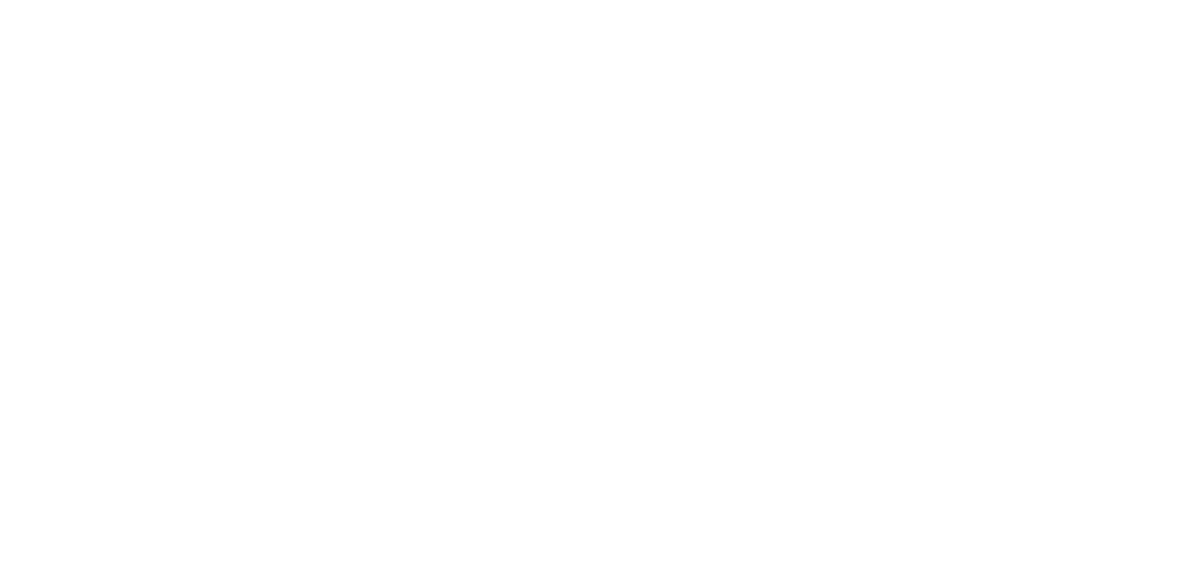

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tranparent" which is no longer supported as of 3.3 and will become an error two minor releases later


<IPython.core.display.Javascript object>


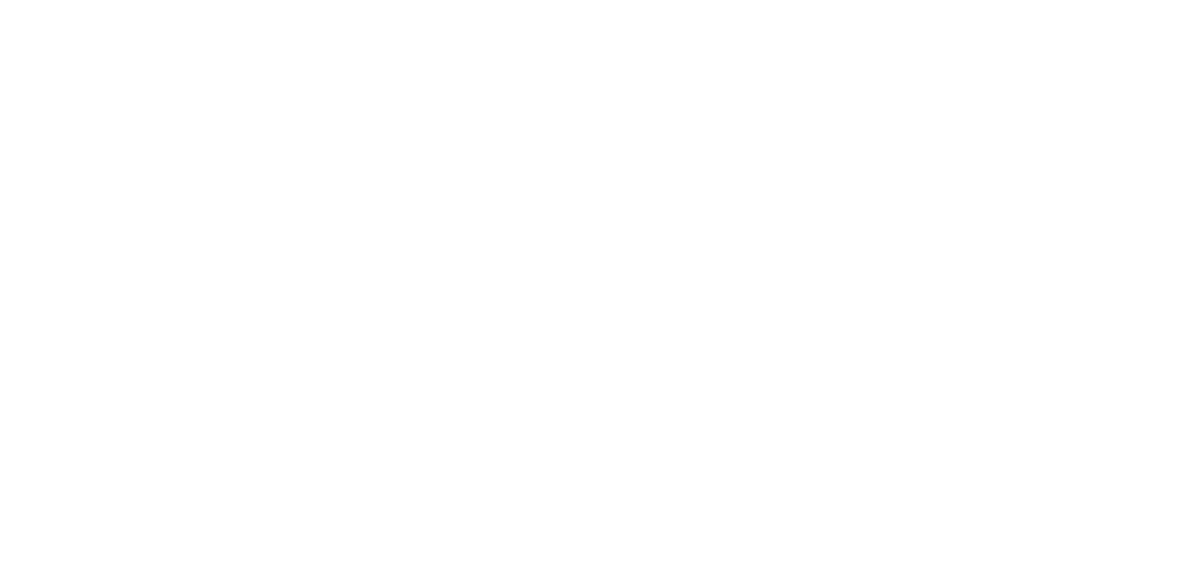

In [36]:
%matplotlib notebook
_single_im_size=1.25
_num_cols = 7
_num_rows =  int(np.ceil(len(class_2_summary_dict)/_num_cols))
fig, axes_list = plt.subplots(_num_rows, _num_cols, 
                              figsize=(_single_im_size*_num_cols, _single_im_size*_num_rows*1.1), 
                              dpi=125,
                              sharex=True, sharey=True)
class_names = list(class_2_summary_dict.keys())
_plot_id = 0
for _row_axes in axes_list:
    for _ax in _row_axes:
        if _plot_id >= len(class_names):
            continue
        _cis_mat = distance.assemble_ChrDistDict_2_Matrix(class_2_summary_dict[class_names[_plot_id]], 
                                                          codebook_df, use_cis=True)/1000
        _ax = ia.figure_tools.distmap.plot_distance_map(
            _cis_mat, color_limits=[0.5,4.5],
            ticks=(_labels_edges[1:] + _labels_edges[:-1])/2,
            tick_labels=_ordered_chr_names,
            font_size=6.5,
            ax=_ax,)
        _ax.set_title(f"{class_names[_plot_id]}, N={len(class_2_chr_zxys[class_names[_plot_id]])}", 
                      fontsize=7.5, pad=2)
        _ax.hlines(_labels_edges, 0, len(_cis_mat), color='black', linewidth=0.25)
        _ax.vlines(_labels_edges, 0, len(_cis_mat), color='black', linewidth=0.25)
        _ax.xaxis.set_tick_params(which='both', labelbottom=True)
        _ax.yaxis.set_tick_params(which='both', labelleft=True)
        # next plot
        _plot_id += 1
        
fig.subplots_adjust(wspace=0.15, hspace=0.15, left=0.02, right=0.97, top=0.97, bottom=0.02)


if visualize_chr:
    sel_chr = '7'
    sel_chr_inds = chr_2_indices[sel_chr]
    _ax.set_xlim([min(sel_chr_inds), max(sel_chr_inds)])
    _ax.set_ylim([ max(sel_chr_inds), min(sel_chr_inds)])
    fig.savefig(os.path.join(figure_folder, f"all_type_cis_median_distmap_chr-{sel_chr}.png"),
                tranparent=True)
else:
    fig.savefig(os.path.join(figure_folder, f"all_type_cis_median_distmap.png"),
                tranparent=True)
fig.show()

# 4. calculate loss-rate per region (NOT FINISHED)

<IPython.core.display.Javascript object>


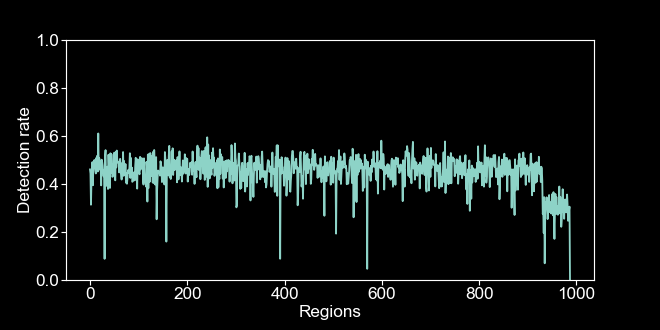

\\mendel\Mendel_SSD4\Pu_Temp\20220307-P_brain_CTP11_from_0303\Decoder\Figures\loss_rates.png


In [197]:
all_zxys = np.concatenate(all_zxys_list)
loss_rates = np.mean(np.isnan(all_zxys).any(2), axis=0)

fig, ax = plt.subplots(figsize=(4,2),dpi=150)
_l = ax.plot(1-loss_rates, linewidth=0.8)
ax.set_ylim([0,1])
ax.set_xlabel('Regions', labelpad=1, fontsize=7.5)
ax.set_ylabel('Detection rate', labelpad=1, fontsize=7.5)

# border
[i[1].set_linewidth(0.5) for i in ax.spines.items()]
# ticks
ax.tick_params('both', labelsize=7.5, 
               width=0.5, length=2,
               pad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1,)
if save_figure:
    loss_rate_fig_fl = os.path.join(figure_folder, 'loss_rates.png')
    print(loss_rate_fig_fl)
    fig.savefig(loss_rate_fig_fl, transparent=True)
fig.show()

# 5. Calculate emsumble median distance

In [37]:
%%time
all_summary_dict = distance.batch_convert_Chr2ZxysList(all_chr_2_zxys_list, codebook_df,)

  0%|                                                                             | 4/18718 [00:00<10:18, 30.28it/s]

- Batch process 18718 chr_2_zxys dicts


  8%|██████▎                                                                     | 21/252 [07:35<1:25:45, 22.27s/it]E:\Users\puzheng\AppData\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
100%|█████████████████████████████████████████████████████████████████████████████| 252/252 [46:47<00:00, 11.14s/it]


Wall time: 3h 47min 53s


In [38]:
# save
save_all_summary_dict = os.path.join(decoder_folder, f"all_summary_dict_n{len(all_chr_2_zxys_list)}.pkl")
print(save_all_summary_dict)
pickle.dump(all_summary_dict, open(save_all_summary_dict, 'wb'))

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests\all_summary_dict_n18718.pkl


## 5.1 plot

In [39]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

<IPython.core.display.Javascript object>


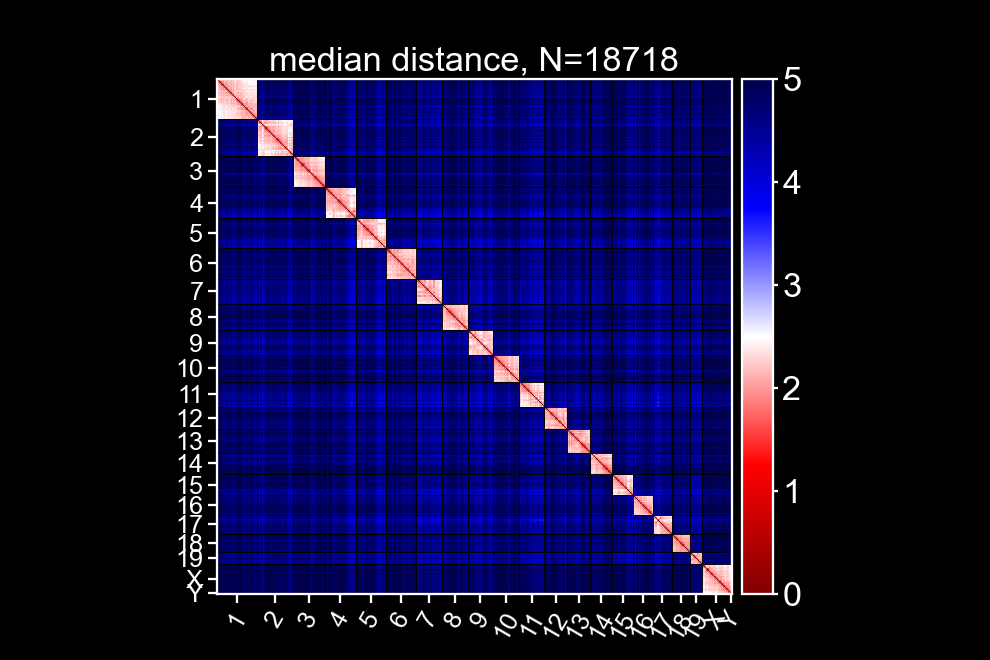

In [42]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

_cis_mat = distance.assemble_ChrDistDict_2_Matrix(all_summary_dict, codebook_df, use_cis=True)/1000

ia.figure_tools.distmap.plot_distance_map(_cis_mat, color_limits=[0.,5],
                                          ax=ax,
                                          )
ax.set_title(f'median distance, N={len(all_chr_2_zxys_list)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(_cis_mat), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(_cis_mat), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()

<IPython.core.display.Javascript object>


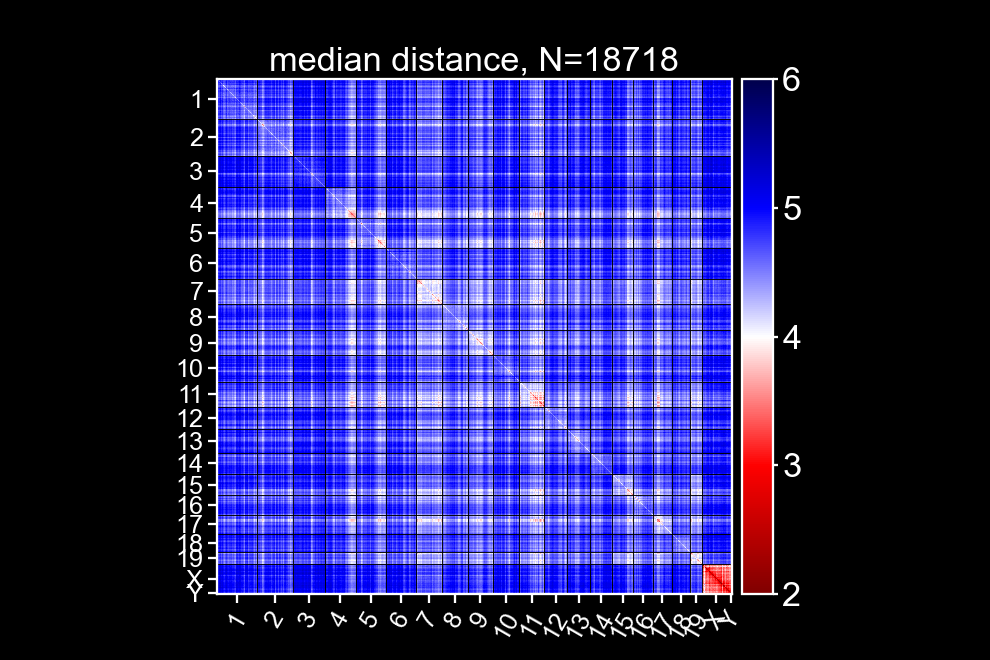

In [46]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

_trans_mat = distance.assemble_ChrDistDict_2_Matrix(all_summary_dict, codebook_df, use_cis=False)/1000

ia.figure_tools.distmap.plot_distance_map(_trans_mat, color_limits=[2.,6],
                                          ax=ax,
                                          )
ax.set_title(f'median distance, N={len(all_chr_2_zxys_list)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(_trans_mat), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(_trans_mat), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_trans_median_distmap.png'), transparent=True)
fig.show()